# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1Ggrd1crQyjbsgw8reN9zhAC2fxp6oHsw#scrollTo=m5cNdUAcjBPs

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
)

In [1]:
# import libaries
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, datasets


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# extract Dataset
import zipfile

with zipfile.ZipFile('Lab3 Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('Lab3 Dataset')

In [7]:
# define a map between output tensor values to its class
CLASSES = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

In [8]:
# define the data transformations
data_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5),
                             (0.5, 0.5, 0.5))
    ])

# load the dataset using ImageFolder
dataset = datasets.ImageFolder(root='Lab3 Dataset/Lab3_Gestures_Summer', transform=data_transform)

In [9]:
# helper function to show an image
def get_data_loader(batch_size=1):
    """
    Load the dataset and return the train, validation and test dataloaders

    Args:
        batch_size: the number of images in a batch
    Returns:
        train_loader: torch dataloaders for training
        val_loader: torch dataloaders for validation
        test_loader: torch dataloaders for testing datasets
    """
    # define the data transformations
    data_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5),
                                (0.5, 0.5, 0.5))
        ])

    # load the dataset
    dataset = datasets.ImageFolder(root='Lab3 Dataset/Lab3_Gestures_Summer', transform=data_transform)
    dataset_size = len(dataset)
    train_size = int(0.7 * dataset_size)  # 70% for training
    val_size = int(0.15 * dataset_size)    # 15% for validation
    test_size = dataset_size - train_size - val_size  # Remaining 15% for testing

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    # Create data loaders with the specified batch size
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        total_err += (predicted != labels).sum().item()
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss
###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

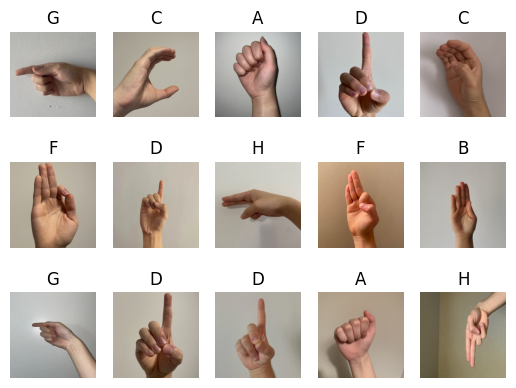

In [10]:
# display a random image from the dataset
import matplotlib.pyplot as plt

k = 0
train_loader, validation_loader, test_loader = get_data_loader()
for images, labels in train_loader:
    image = images[0]
    img = image.numpy().transpose((1, 2, 0))
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.title(CLASSES[labels.item()])
    plt.imshow(img)
    k += 1
    if k > 14:
        break

In [11]:
# number of pictures in total
print('Total number of images in the dataset: ', len(train_loader) + len(validation_loader) + len(test_loader))
# number of pictures in training, validation and test set
print('Number of images in the training set: ', len(train_loader))
print('Number of images in the validation set: ', len(validation_loader))
print('Number of images in the test set: ', len(test_loader))

Total number of images in the dataset:  2219
Number of images in the training set:  1553
Number of images in the validation set:  332
Number of images in the test set:  334


I've split the dataset into three sets of data: training set, validation set, and testing set. The training set will be used for training, validation will be used for fine-tuning the hyperparameter, and test data will only be used to inform us with the final accuracy of the model.

The dataset is randomly split into 70% training, 15% validation, and 15% test set. There are a variety of popular ways to split the dataset, with the common one's being 80:20 training-validation/test split, and 70:30 split. I chose the 70:30 split because it is best used for smaller datasets.

### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.name = "cnn"
        # 3 convolutional layers used, with max pooling after each
        self.conv1 = nn.Conv2d(3, 5, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 8, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(8, 12, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        # 2 fully connected layers
        self.fc1 = nn.Linear(12 * 26 * 26, 500)
        self.fc2 = nn.Linear(500, 9)
    def forward(self, x):
        # ReLU activation function used after each convolutional and linear layer
        x = self.pool1(F.relu(self.conv1(x))) # 5x111x111
        x = self.pool2(F.relu(self.conv2(x))) # 8x54x54
        x = self.pool3(F.relu(self.conv3(x))) # 12x26x26
        x = x.view(-1, 12 * 26 * 26)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [13]:
# training function
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader = get_data_loader(batch_size)
    # Define the loss criterion and the training algorithm
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    # Track the error and loss over epochs
    train_err = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    # Train the network
    start_time = time.time()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            _, predicted = torch.max(outputs.data, 1)
            total_train_err += (predicted != labels).sum().item()
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(
            f"Epoch {epoch + 1}: Train err: {train_err[epoch]}, Train loss: {train_loss[epoch]} | "
            f"Validation err: {val_err[epoch]}, Validation loss: {val_loss[epoch]}"
        )

        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [14]:
# make a small dataset that contains 3 images from each class
def make_small_dataset(batch_size = 1):

    data_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5),
                                (0.5, 0.5, 0.5))
        ])
    train_dataset = torchvision.datasets.ImageFolder(root='Lab3 Dataset/Lab3_Gestures_Summer', transform=data_transform)
    # Create a new dataset with only 3 images per label
    small_dataset = []
    count_per_label = {}

    for image, label in train_dataset:
        if label not in count_per_label:
            count_per_label[label] = 0

        if count_per_label[label] < 3:
            small_dataset.append((image, label))
            count_per_label[label] += 1

        if len(small_dataset) == 3 * len(train_dataset.classes):
            break
    small_dataset = torch.utils.data.DataLoader(small_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
    return small_dataset

# training function
def train_net_small_database(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader =  make_small_dataset(batch_size)
    # Define the loss criterion and the training algorithm
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    # Track the error and loss over epochs
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)

    # Train the network
    start_time = time.time()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            _, predicted = torch.max(outputs.data, 1)
            total_train_err += (predicted != labels).float().mean()
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err)
        train_loss[epoch] = float(total_train_loss) / (i+1)
        print(
            f"Epoch {epoch + 1}: Train err: {train_err[epoch]}, Train loss: {train_loss[epoch]} "
        )
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)


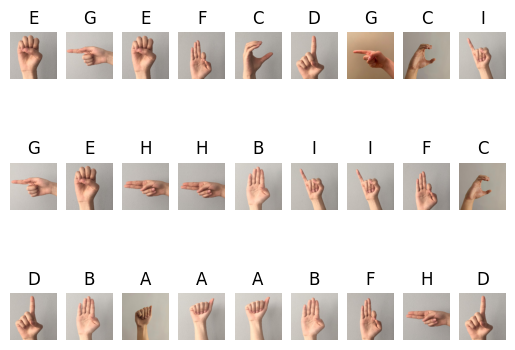

In [15]:
small_dataset = make_small_dataset()
k = 0
for images, labels in small_dataset:
    image = images[0]
    img = image.numpy().transpose((1, 2, 0))
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 9, k+1)
    plt.axis('off')
    plt.title(CLASSES[labels.item()])
    plt.imshow(img)
    k += 1
    if k > 27:
        break

In [16]:
# train the network
net = CNN()
train_net_small_database(net, batch_size=27, learning_rate=0.01, num_epochs=100)

Epoch 1: Train err: 0.8888888955116272, Train loss: 2.197632312774658 
Epoch 2: Train err: 0.8888888955116272, Train loss: 2.19747257232666 
Epoch 3: Train err: 0.8888888955116272, Train loss: 2.1972134113311768 
Epoch 4: Train err: 0.8888888955116272, Train loss: 2.1969244480133057 
Epoch 5: Train err: 0.8888888955116272, Train loss: 2.1966230869293213 
Epoch 6: Train err: 0.8888888955116272, Train loss: 2.196331024169922 
Epoch 7: Train err: 0.8888888955116272, Train loss: 2.196042060852051 
Epoch 8: Train err: 0.8888888955116272, Train loss: 2.195783853530884 
Epoch 9: Train err: 0.8888888955116272, Train loss: 2.19553279876709 
Epoch 10: Train err: 0.8888888955116272, Train loss: 2.1952600479125977 
Epoch 11: Train err: 0.8888888955116272, Train loss: 2.1949667930603027 
Epoch 12: Train err: 0.8888888955116272, Train loss: 2.1946656703948975 
Epoch 13: Train err: 0.8888888955116272, Train loss: 2.194350242614746 
Epoch 14: Train err: 0.8888888955116272, Train loss: 2.19401669502258

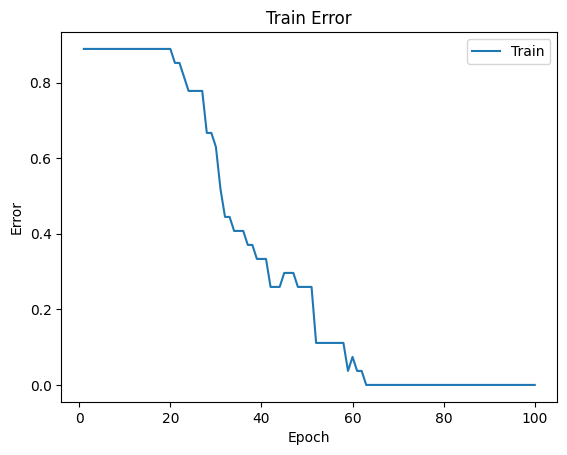

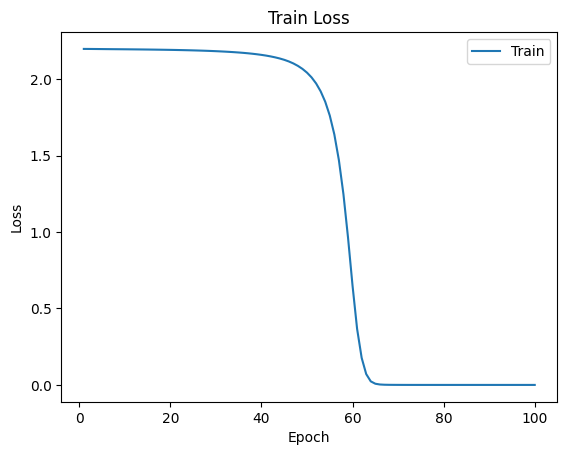

In [17]:
path = get_model_name("cnn", batch_size=27, learning_rate=0.01, epoch=99)
train_err = np.loadtxt("{}_train_err.csv".format(path))
train_loss = np.loadtxt("{}_train_loss.csv".format(path))
plt.title("Train Error")
n = len(train_err) # number of epochs
plt.plot(range(1,n+1), train_err, label="Train")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend(loc='best')
plt.show()
plt.title("Train Loss")
plt.plot(range(1,n+1), train_loss, label="Train")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

### 3. Hyperparameter Search [10 pt]

### Part (a) - 1 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

**Answer**

3 hyperparameters worth tuning are:
- Number of layers of convolution
- size of filter/kernel
- padding

I'm going to tune the size of filter/kernel.

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

Default setting:
- Layer 1: 3x3
- Layer 2: 3x3
- Layer 3: 3x3

Best Validation Error: 0.1596

Validation Loss: 0.9172

Epoch 1: Train err: 0.8081133290405667, Train loss: 2.1880379581451415 | Validation err: 0.7771084337349398, Validation loss: 2.1620675722757974
Epoch 2: Train err: 0.6149388280746941, Train loss: 1.8732929086685182 | Validation err: 0.4939759036144578, Validation loss: 1.447447657585144
Epoch 3: Train err: 0.44108177720540886, Train loss: 1.273264319896698 | Validation err: 0.39156626506024095, Validation loss: 1.110507180293401
Epoch 4: Train err: 0.3696072118480361, Train loss: 1.027293665409088 | Validation err: 0.37650602409638556, Validation loss: 1.1452873349189758
Epoch 5: Train err: 0.30006439150032194, Train loss: 0.8635994064807891 | Validation err: 0.3373493975903614, Validation loss: 0.928276389837265
Epoch 6: Train err: 0.26851255634256277, Train loss: 0.7791601943969727 | Validation err: 0.26506024096385544, Validation loss: 0.908798615137736
Epoch 7: Train err: 0.262073406310367, Train loss: 0.7434050130844116 | Validation err: 0.3072289156626506, Validation loss: 0.901

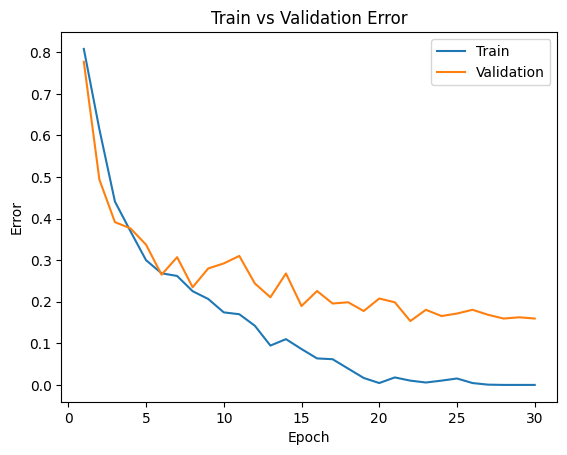

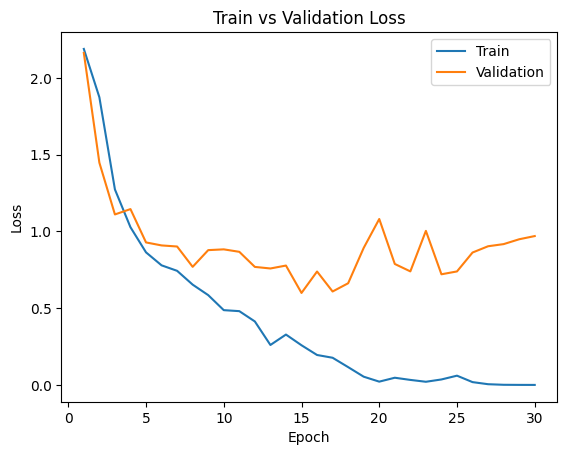

In [18]:
net = CNN()
train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30)
plot_training_curve(get_model_name(net.name, batch_size=64, learning_rate=0.01, epoch=29))

Model

- Layer 1: 3x3 kernel
- Layer 2: 3x3 kernel
- Layer 3: 5x5 kernel

Best Validation Error: 0.1566

Validation Loss: 0.920

In [19]:
# model with 3x3, 3x3, 5x5
class CNN_3_3_5(nn.Module):
    def __init__(self):
        super(CNN_3_3_5, self).__init__()
        self.name = "cnn_3_3_5"
        # 3 convolutional layers used, with max pooling after each
        self.conv1 = nn.Conv2d(3, 5, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 8, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(8, 12, 5)
        self.pool3 = nn.MaxPool2d(2, 2)
        # 2 fully connected layers
        self.fc1 = nn.Linear(12 * 25 * 25, 500)
        self.fc2 = nn.Linear(500, 9)
    def forward(self, x):
        # ReLU activation function used after each convolutional and linear layer
        x = self.pool1(F.relu(self.conv1(x))) # 5x111x111
        x = self.pool2(F.relu(self.conv2(x))) # 8x54x54
        x = self.pool3(F.relu(self.conv3(x))) # 12x25x25
        x = x.view(-1, 12 * 25 * 25)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch 1: Train err: 0.8989053444945267, Train loss: 2.197428150177002 | Validation err: 0.8253012048192772, Validation loss: 2.196238398551941
Epoch 2: Train err: 0.8731487443657437, Train loss: 2.1944129562377928 | Validation err: 0.9246987951807228, Validation loss: 2.195311705271403
Epoch 3: Train err: 0.8783000643915003, Train loss: 2.188229560852051 | Validation err: 0.9006024096385542, Validation loss: 2.1869423389434814
Epoch 4: Train err: 0.7611075338055376, Train loss: 2.1112518453598024 | Validation err: 0.6114457831325302, Validation loss: 1.8262919982274373
Epoch 5: Train err: 0.531873792659369, Train loss: 1.4887059593200684 | Validation err: 0.4427710843373494, Validation loss: 1.278613030910492
Epoch 6: Train err: 0.37411461687057307, Train loss: 1.1313247227668761 | Validation err: 0.33433734939759036, Validation loss: 0.9961628317832947
Epoch 7: Train err: 0.32582099162910494, Train loss: 0.9620234823226929 | Validation err: 0.32228915662650603, Validation loss: 1.0031

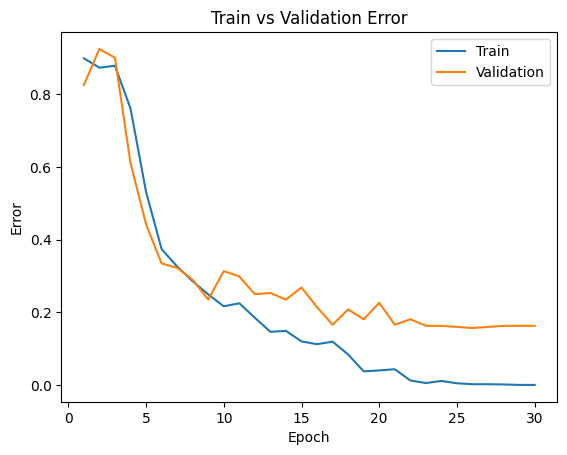

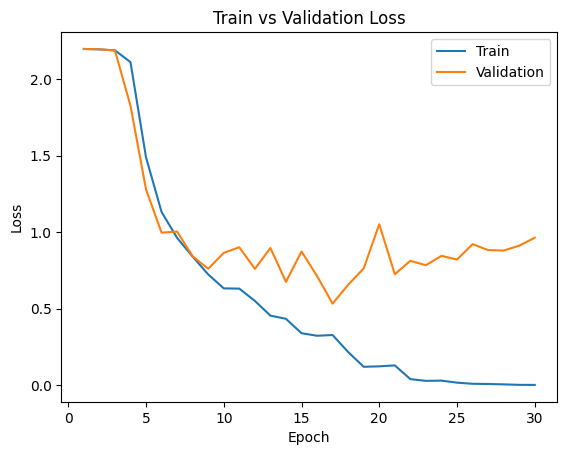

In [20]:
net = CNN_3_3_5()
train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30)
plot_training_curve(get_model_name(net.name, batch_size=64, learning_rate=0.01, epoch=29))

Model:

- Layer 1: 5x5 kernel
- Layer 2: 5x5 kernel
- layer 3: 5x5 kernel

Best Validation Error: 0.1385

Validation Loss: 1.037

In [34]:
# model with 5x5, 5x5, 5x5
class CNN_5_5_5(nn.Module):
    def __init__(self):
        super(CNN_5_5_5, self).__init__()
        self.name = "cnn_5_5_5"
        # 3 convolutional layers used, with max pooling after each
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 8, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(8, 12, 5)
        self.pool3 = nn.MaxPool2d(2, 2)
        # 2 fully connected layers
        self.fc1 = nn.Linear(12 * 24 * 24, 500)
        self.fc2 = nn.Linear(500, 9)
    def forward(self, x):
        # ReLU activation function used after each convolutional and linear layer
        x = self.pool1(F.relu(self.conv1(x))) # 5x110x110
        x = self.pool2(F.relu(self.conv2(x))) # 8x53x53
        x = self.pool3(F.relu(self.conv3(x))) # 12x24x24
        x = x.view(-1, 12 * 24 * 24)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch 1: Train err: 0.8840952994204765, Train loss: 2.197050838470459 | Validation err: 0.9246987951807228, Validation loss: 2.1978740294774375
Epoch 2: Train err: 0.8737926593689633, Train loss: 2.1876955890655516 | Validation err: 0.8313253012048193, Validation loss: 2.1666754484176636
Epoch 3: Train err: 0.6245975531229878, Train loss: 1.8571529483795166 | Validation err: 0.5421686746987951, Validation loss: 1.5566803614298503
Epoch 4: Train err: 0.459111397295557, Train loss: 1.2965576720237733 | Validation err: 0.39457831325301207, Validation loss: 1.1748668154080708
Epoch 5: Train err: 0.33869929169349644, Train loss: 1.0045020437240602 | Validation err: 0.3493975903614458, Validation loss: 1.0242083768049877
Epoch 6: Train err: 0.31101094655505473, Train loss: 0.9007812380790711 | Validation err: 0.2620481927710843, Validation loss: 0.8567152619361877
Epoch 7: Train err: 0.25949774629748873, Train loss: 0.7809613358974457 | Validation err: 0.2891566265060241, Validation loss: 1.

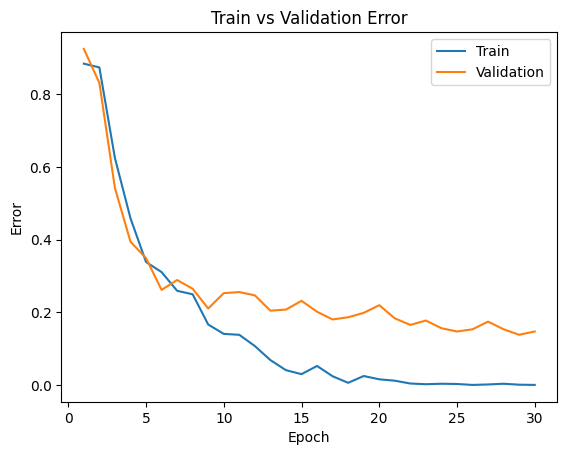

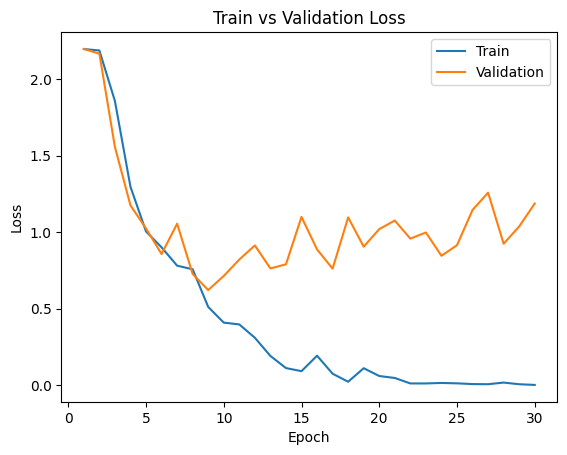

In [35]:
net = CNN_5_5_5()
train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30)
plot_training_curve(get_model_name(net.name, batch_size=64, learning_rate=0.01, epoch=29))

Model:

- Layer 1: 5x5 kernel
- Layer 2: 5x5 kernel
- layer 3: 3x3 kernel

Final Validation Error: 0.141

Final Validation Loss: 1.035

In [36]:
# model with 5x5, 5x5, 5x5
class CNN_5_5_3(nn.Module):
    def __init__(self):
        super(CNN_5_5_3, self).__init__()
        self.name = "cnn_5_5_3"
        # 3 convolutional layers used, with max pooling after each
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 8, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(8, 12, 3)
        self.pool3 = nn.MaxPool2d(2, 2)
        # 2 fully connected layers
        self.fc1 = nn.Linear(12 * 25 * 25, 500)
        self.fc2 = nn.Linear(500, 9)
    def forward(self, x):
        # ReLU activation function used after each convolutional and linear layer
        x = self.pool1(F.relu(self.conv1(x))) # 5x110x110
        x = self.pool2(F.relu(self.conv2(x))) # 8x53x53
        x = self.pool3(F.relu(self.conv3(x))) # 12x25x25
        x = x.view(-1, 12 * 25 * 25)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch 1: Train err: 0.8815196394075981, Train loss: 2.197172927856445 | Validation err: 0.8795180722891566, Validation loss: 2.1979435682296753
Epoch 2: Train err: 0.8725048293625242, Train loss: 2.1893949413299563 | Validation err: 0.8795180722891566, Validation loss: 2.1824090083440146
Epoch 3: Train err: 0.7630392788151964, Train loss: 2.060078101158142 | Validation err: 0.6897590361445783, Validation loss: 1.9281734824180603
Epoch 4: Train err: 0.6484224082421121, Train loss: 1.7512727928161622 | Validation err: 0.5030120481927711, Validation loss: 1.2630592584609985
Epoch 5: Train err: 0.4172569220862846, Train loss: 1.2054067754745483 | Validation err: 0.35843373493975905, Validation loss: 0.9801324804623922
Epoch 6: Train err: 0.33547971667739857, Train loss: 0.9951213335990906 | Validation err: 0.27710843373493976, Validation loss: 0.889885942141215
Epoch 7: Train err: 0.2781712813908564, Train loss: 0.8251873564720154 | Validation err: 0.2680722891566265, Validation loss: 0.84

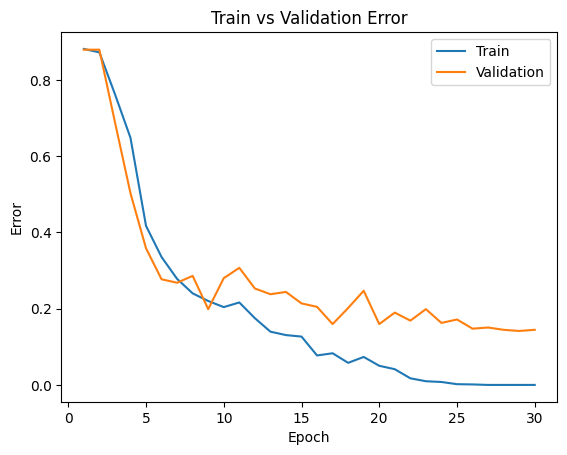

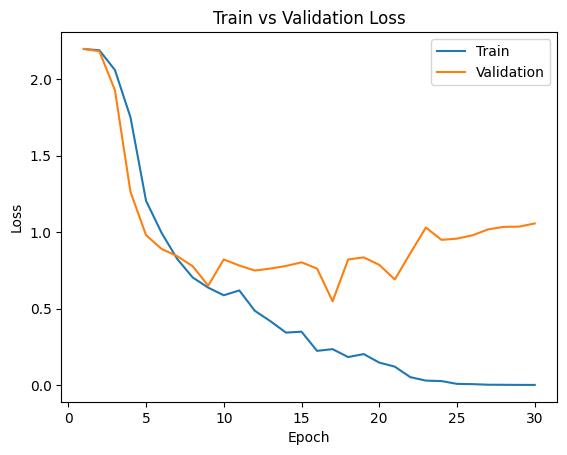

In [37]:
net = CNN_5_5_3()
train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30)
plot_training_curve(get_model_name(net.name, batch_size=64, learning_rate=0.01, epoch=29))

### Part (c) - 2 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

**Answer**

I'm going to pick the model with the 5x5, 5x5, 5x5 (cnn_5_5_5). All 4 models have similar accuracy / loss at the end of training, but cnn_5_5_5 have the highest accuracy (lowest loss) while only having slightly higher loss compared to others.

### Part (d) - 2 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [69]:
net = CNN_5_5_5()
model_path = get_model_name(net.name, batch_size=64, learning_rate=0.01, epoch=28) # best validation loss
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

In [70]:
# make sure the test dataset is the same, and that it didn't see it before
torch.manual_seed(1000)
_, _, test_loader = get_data_loader(batch_size=64)
criterion = nn.CrossEntropyLoss()
test_err, test_loss = evaluate(net, test_loader, criterion)
print(f"Test classification error: {test_err}, Test loss: {test_loss}")

Test classification error: 0.19161676646706588, Test loss: 1.6785404185454051


### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [52]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:05<00:00, 48.6MB/s]


The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [53]:
import os

def get_feature(data_name, data_loader):
    n = 0
    for images, labels in data_loader:
        features = alexnet.features(images)
        features_tensor = torch.from_numpy(features.detach().numpy())
        folder_path = './AlexNet Features/' + data_name+'/' \
                    + CLASSES[labels.item()] + '/'
        os.makedirs(folder_path, exist_ok=True)  # Create the folder if it doesn't exist
        torch.save(features_tensor.squeeze(0), folder_path + str(n)+ '.tensor')
        n += 1

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [54]:
train_loader, val_loader, test_loader = get_data_loader(batch_size=1)
# get the featurse for train, validation, and test
get_feature("training", train_loader)
get_feature("validation", val_loader)
get_feature("test", test_loader)

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

**Answer**

My model only have 2 fully connected layers. The reason for this is because this model builds on-top of AlexNet's convolutional feature output. AlexNet has 6 layers of convolution, which means my model only need 2 fully connected layers to interpret the results.

In [86]:
class transfer_cnn(nn.Module):
    def __init__(self):
        super(transfer_cnn, self).__init__()
        self.name = "transfer_cnn"
        self.fc1 = nn.Linear(256 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 9)
    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [87]:
train_data = torchvision.datasets.DatasetFolder('./AlexNet Features/training', loader=torch.load, extensions=('.tensor'))
val_data = torchvision.datasets.DatasetFolder('./AlexNet Features/validation', loader=torch.load, extensions=('.tensor'))
test_data = torchvision.datasets.DatasetFolder('./AlexNet Features/test', loader=torch.load, extensions=('.tensor'))

In [88]:
# training function
def train_net_transfer(net, batch_size=64, learning_rate=0.005, num_epochs=30):
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
    # Define the loss criterion and the training algorithm
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    # Track the error and loss over epochs
    train_err = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    # Train the network
    start_time = time.time()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            _, predicted = torch.max(outputs.data, 1)
            total_train_err += (predicted != labels).sum().item()
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(
            f"Epoch {epoch + 1}: Train err: {train_err[epoch]}, Train loss: {train_loss[epoch]} | "
            f"Validation err: {val_err[epoch]}, Validation loss: {val_loss[epoch]}"
        )

        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

Epoch 1: Train err: 0.47005795235028974, Train loss: 1.3476730751991273 | Validation err: 0.21686746987951808, Validation loss: 0.5517306451996168
Epoch 2: Train err: 0.13071474565357372, Train loss: 0.4176189452409744 | Validation err: 0.10240963855421686, Validation loss: 0.269013171394666
Epoch 3: Train err: 0.06889890534449453, Train loss: 0.22994849652051927 | Validation err: 0.08734939759036145, Validation loss: 0.259763407210509
Epoch 4: Train err: 0.03734707018673535, Train loss: 0.15073712766170502 | Validation err: 0.07228915662650602, Validation loss: 0.20773236577709517
Epoch 5: Train err: 0.015453960077269801, Train loss: 0.08014248713850974 | Validation err: 0.0783132530120482, Validation loss: 0.1978287771344185
Epoch 6: Train err: 0.016097875080489377, Train loss: 0.06630168229341507 | Validation err: 0.06325301204819277, Validation loss: 0.24177412192026773
Epoch 7: Train err: 0.0077269800386349004, Train loss: 0.04926045544445515 | Validation err: 0.06626506024096386,

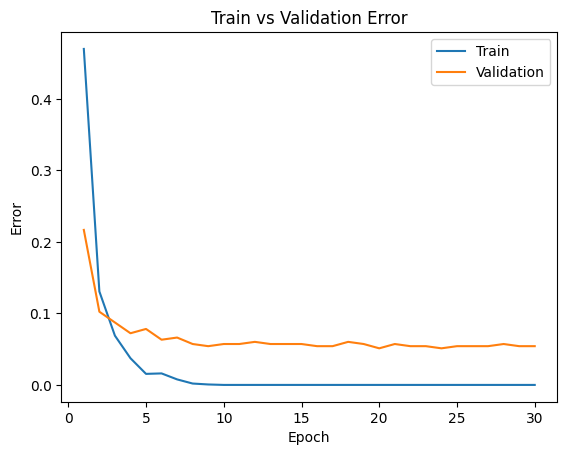

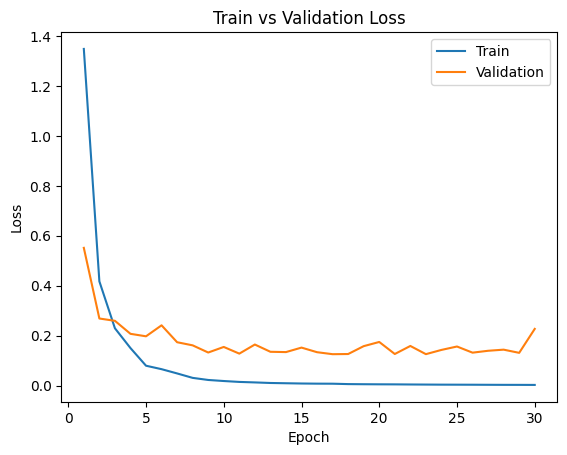

In [89]:
net = transfer_cnn()
train_net_transfer(net)
plot_training_curve(get_model_name(net.name, batch_size=64, learning_rate=0.005, epoch=29))

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

**Answer**

Best model is at epoch 23 with validation error of 0.0512, and validation loss of 0.143.

The test error is 0.0598, and test loss is 0.294. This is much better than my model without transfer learning.

In [95]:
net = transfer_cnn()
model_path = get_model_name(net.name, batch_size=64, learning_rate=0.005, epoch=23)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

In [91]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)
criterion = nn.CrossEntropyLoss()
test_err, test_loss = evaluate(net, test_loader, criterion)
print(f"Test classification error: {test_err}, Test loss: {test_loss}")

Test classification error: 0.059880239520958084, Test loss: 0.29481002936760586


### 5. Additional Testing [5 pt]
As a final step in testing we will be revisiting the sample images that you had collected and submitted at the start of this lab. These sample images should be untouched and will be used to demonstrate how well your model works at identifying your hand guestures.

Using the best transfer learning model developed in Part 4. Report the test accuracy on your sample images and how it compares to the test accuracy obtained in Part 4(d)? How well did your model do for the different hand guestures? Provide an explanation for why you think your model performed the way it did?

Epoch 1: Train err: 0.3245331616226658, Train loss: 0.90968685545798 | Validation err: 0.1144578313253012, Validation loss: 0.33673395159152836
Epoch 2: Train err: 0.08821635544108178, Train loss: 0.2689312615528189 | Validation err: 0.08734939759036145, Validation loss: 0.30123510555579114
Epoch 3: Train err: 0.04056664520283323, Train loss: 0.12849188782274723 | Validation err: 0.10240963855421686, Validation loss: 0.2875823470262381
Epoch 4: Train err: 0.03477141017385705, Train loss: 0.09468916630179718 | Validation err: 0.060240963855421686, Validation loss: 0.19987711711571768
Epoch 5: Train err: 0.008370895041854474, Train loss: 0.0489902314810275 | Validation err: 0.05421686746987952, Validation loss: 0.18885389242607814
Epoch 6: Train err: 0.004507405022537025, Train loss: 0.023703133851964157 | Validation err: 0.060240963855421686, Validation loss: 0.23565076406185442
Epoch 7: Train err: 0.00128783000643915, Train loss: 0.015533615208776861 | Validation err: 0.054216867469879

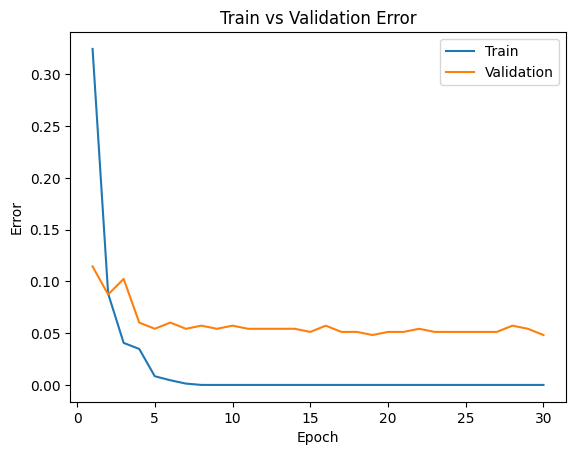

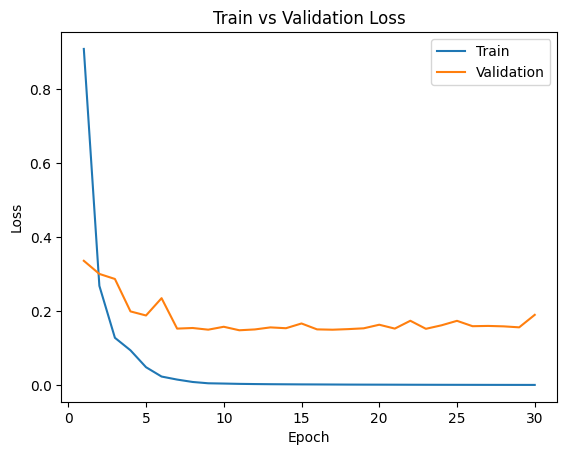

In [92]:
# have to train a dataset with batch_size 27
net = transfer_cnn()
train_net_transfer(net, batch_size=27)
plot_training_curve(get_model_name(net.name, batch_size=27, learning_rate=0.005, epoch=29))

In [93]:
# epoch 24 has the best validation error
net = transfer_cnn()
model_path = get_model_name(net.name, batch_size=27, learning_rate=0.005, epoch=24)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

In [98]:
small_database_loader = make_small_dataset(1)
# get the features of small database
get_feature("small_database", small_database_loader)
small_database_dataset = torchvision.datasets.DatasetFolder('./AlexNet Features/small_database', loader=torch.load, extensions=('.tensor'))

In [100]:
small_database_loader = torch.utils.data.DataLoader(small_database_dataset, batch_size=27, shuffle=True)
criterion = nn.CrossEntropyLoss()
test_err, test_loss = evaluate(net, test_loader, criterion)
print(f"Small Dataset Test classification error: {test_err}, Test loss: {test_loss}")

Small Dataset Test classification error: 0.059880239520958084, Test loss: 0.21275155091037354


The small dataset error is similar to the test score, because it came from the same dataset.